In [1]:
# Importing our Utilities functions:
from utils import CautDataloaderRegular
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# Modelling
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# 64, 32
# 32, 16
def LSTM_grid_search(csv_path,
                     visual_data_dir,
                     visual_data_mode,
                     audio_data_dir,
                     fusion_mode,
                     visual_approach_type,
                     audio_feature_type,
                     lstm_feat_size_lst=[16, 32, 64, 128, 256],
                     inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                     epochs_num=100,
                     batch_size=32,
                     threshold=0.5,
                     required_FPS=30,
                     input_length_in_seconds=3,
                     class_to_num_dict={"truth": 0, "lie": 1},
                     train_verbose=False):
    for lstm_feat_size_tmp in lstm_feat_size_lst:
        for inner_dense_size_tmp in inner_dense_layer_size_lst:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            print(f"LSTM Layer Size       : {lstm_feat_size_tmp}")
            print(f"Inner Dense Layer Size: {inner_dense_size_tmp}")
            print(f"Epoch Num             : {epochs_num}")
            LSTM_Model(csv_path=csv_path,
                       visual_data_dir=visual_data_dir,
                       visual_data_mode=visual_data_mode,
                       audio_data_dir=audio_data_dir,
                       # coord_selection,
                       fusion_mode=fusion_mode,
                       visual_approach_type=visual_approach_type,  # average or frame-based
                       audio_feature_type=audio_feature_type,  # MFCC, RMS, Chroma
                       lstm_features_size=lstm_feat_size_tmp,
                       inner_dense_size=inner_dense_size_tmp,
                       epochs_num=epochs_num,
                       batch_size=batch_size,
                       threshold=threshold,
                       required_FPS=required_FPS,
                       input_length_in_seconds=input_length_in_seconds,
                       class_to_num_dict=class_to_num_dict,
                       train_verbose=train_verbose)
            print("\n\n")
            print("##########################################")
            
        
# # Do grid search:
# LSTM_grid_search(lstm_feat_size_lst=[16, 32, 64, 128, 256],
#                  inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
#                  epoch_num=100,
#                  batch_size=32)



def LSTM_Model(csv_path,
               visual_data_dir,
               visual_data_mode,
               audio_data_dir,
               # coord_selection,
               fusion_mode,
               visual_approach_type,  # average or frame-based
               audio_feature_type,  # MFCC, RMS, Chroma
               lstm_features_size,
               inner_dense_size,
               epochs_num,
               batch_size,
               threshold,
               required_FPS,
               input_length_in_seconds,
               class_to_num_dict,
               train_verbose):

    X_y_data = CautDataloaderRegular.get_X_y_TrainTest_Fused(csv_path,
                                                             visual_data_dir,
                                                             visual_data_mode,
                                                             audio_data_dir,
                                                             # coord_selection,
                                                             fusion_mode,
                                                             visual_approach_type=visual_approach_type,  # average or frame-based
                                                             required_FPS=required_FPS,
                                                             input_length_in_seconds=input_length_in_seconds,
                                                             audio_feature_type=audio_feature_type,  # MFCC, RMS, Chroma
                                                             class_to_num_dict=class_to_num_dict,
                                                             verbose=train_verbose)
    
    X_train, y_train = X_y_data[0], X_y_data[1]
    X_test, y_test = X_y_data[2], X_y_data[3]
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # setup model's input length, feature amount, and expected class num
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    n_outputs = 1
    
    # lstm_features_size, inner_dense_size => default 100
    
    # Setup model:
    model = Sequential()
    model.add(LSTM(lstm_features_size, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(inner_dense_size, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # fit network
    epochs = epochs_num
    batch_size = 32
    train_verbose = train_verbose
    # also, add Early stopping:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                               patience=15)
    
    model.fit(X_train,
              y_train,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping_callback],
              verbose=train_verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(X_test,
                                 y_test,
                                 batch_size=batch_size,
                                 verbose=0)
    
    # predict on test data:
    y_pred = model.predict(X_test, batch_size=32) 
    y_pred = np.where(y_pred > threshold, 1, 0)
    
    # get metrics (accuracy, precision, recall)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # log accuracy:
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    
    # show confusion matrix
    CautDataloaderRegular.plot_confusion_matrix(y_test, y_pred)

# MediaPipe (Sequential only, since LSTM can only do sequences):

audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.8251121076233184
Precision 0.8558558558558559
Recall 0.8050847457627118


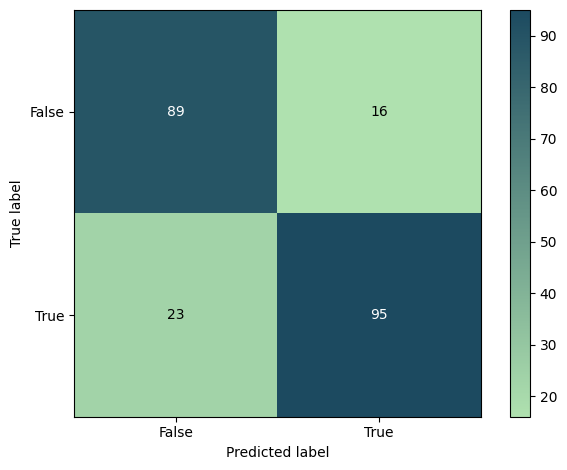

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 95
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 23
     - True Positive Rate       :  0.8050847457627118
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8558558558558559
     - Negative predictive value:  0.7946428571428571
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.19491525423728814
     - False Discovery Rate     :  0.14414414414414414


In [2]:
LSTM_Model(csv_path="../../../data/data_split_paths_CSVs/",
           visual_data_dir="../../../data/visual_features/MediaPipe/mediaPipe_keypoints_data_UPD",
           visual_data_mode="MediaPipe",
           audio_data_dir="../../../data/audio_features/",
           # coord_selection,
           fusion_mode="+",
           visual_approach_type="sequential",  # average or frame-based
           audio_feature_type="MFCC",  # MFCC, RMS, Chroma
           lstm_features_size=100,
           inner_dense_size=32,
           epochs_num=100,
           batch_size=32,
           threshold=0.5,
           required_FPS=30,
           input_length_in_seconds=3,
           class_to_num_dict={"truth": 0, "lie": 1},
           train_verbose=False)

# OpenFace (Sequential only, since LSTM can only do sequences):

audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 3, 47) (520,) (222, 3, 47) (222,)
7/7 [==============================] - 0s 2ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


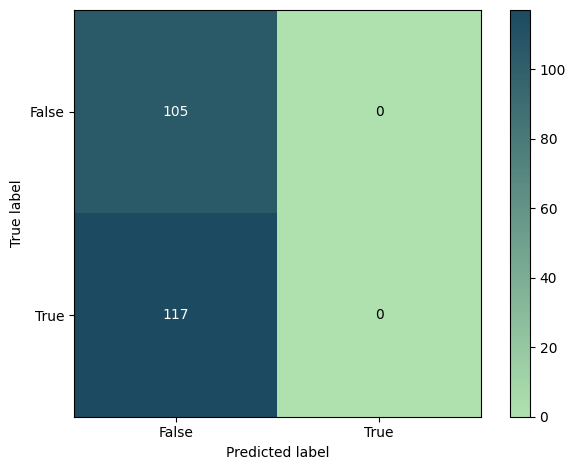

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 0
     - False Positive           : 0
     - True Negative            : 105
     - False Negative           : 117
     - True Positive Rate       :  0.0
     - True Negative Rate       :  1.0
     - Positive Predictive Value:  nan
     - Negative predictive value:  0.47297297297297297
     - False Positive Rate      :  0.0
     - False Negative Rate      :  1.0
     - False Discovery Rate     :  nan


C:\Users\lrspr\Desktop\ml\DeceptionDetection_CAUT\Phase_2\3_Model_Codebase\LSTM_Model_Setup\utils.py:720: RuntimeWarning: invalid value encountered in longlong_scalars
  PPV = TP/(TP+FP)
C:\Users\lrspr\Desktop\ml\DeceptionDetection_CAUT\Phase_2\3_Model_Codebase\LSTM_Model_Setup\utils.py:728: RuntimeWarning: invalid value encountered in longlong_scalars
  FDR = FP/(TP+FP)


In [2]:
LSTM_Model(csv_path="../../../data/data_split_paths_CSVs/",
           visual_data_dir="../../../data/visual_features/OpenFace/PyFeatOutput/OpenFace",
           visual_data_mode="OpenFace",
           audio_data_dir="../../../data/audio_features/",
           # coord_selection,
           fusion_mode="+",
           visual_approach_type="sequential",  # average or frame-based
           audio_feature_type="MFCC",  # MFCC, RMS, Chroma
           lstm_features_size=100,
           inner_dense_size=32,
           epochs_num=100,
           batch_size=32,
           threshold=0.5,
           required_FPS=1,
           input_length_in_seconds=3,
           class_to_num_dict={"truth": 0, "lie": 1},
           train_verbose=False)

# Let's search for good MediaPipe parameter:

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 16
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.7399103139013453
Precision 0.7727272727272727
Recall 0.7203389830508474


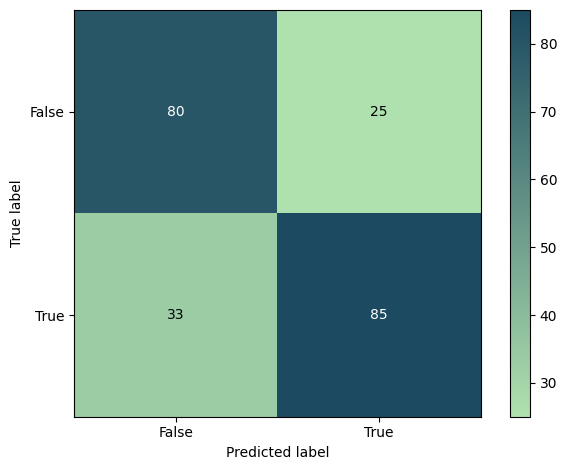

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 85
     - False Positive           : 25
     - True Negative            : 80
     - False Negative           : 33
     - True Positive Rate       :  0.7203389830508474
     - True Negative Rate       :  0.7619047619047619
     - Positive Predictive Value:  0.7727272727272727
     - Negative predictive value:  0.7079646017699115
     - False Positive Rate      :  0.23809523809523808
     - False Negative Rate      :  0.2796610169491525
     - False Discovery Rate     :  0.22727272727272727



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 32
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 5ms/

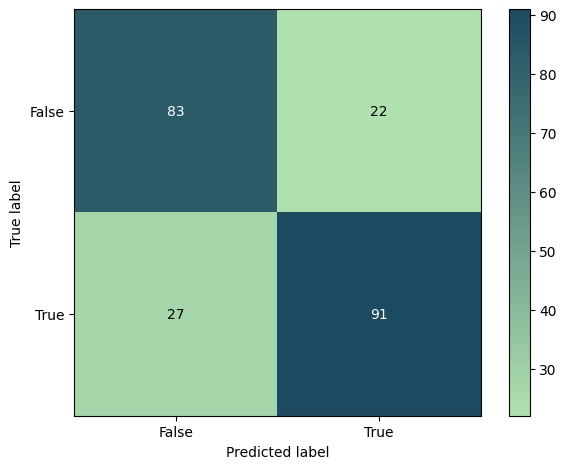

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 91
     - False Positive           : 22
     - True Negative            : 83
     - False Negative           : 27
     - True Positive Rate       :  0.7711864406779662
     - True Negative Rate       :  0.7904761904761904
     - Positive Predictive Value:  0.8053097345132744
     - Negative predictive value:  0.7545454545454545
     - False Positive Rate      :  0.20952380952380953
     - False Negative Rate      :  0.2288135593220339
     - False Discovery Rate     :  0.19469026548672566



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 64
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 5ms/

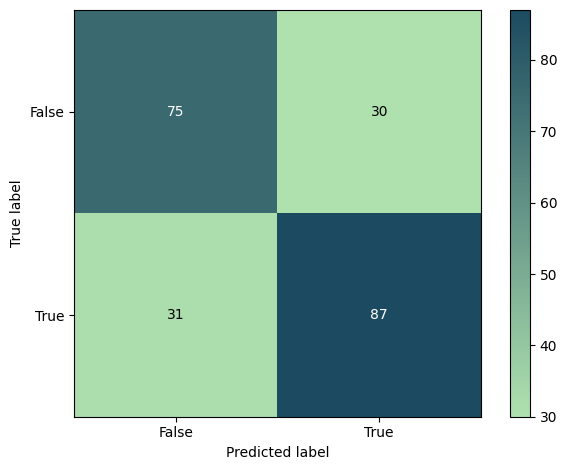

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 87
     - False Positive           : 30
     - True Negative            : 75
     - False Negative           : 31
     - True Positive Rate       :  0.7372881355932204
     - True Negative Rate       :  0.7142857142857143
     - Positive Predictive Value:  0.7435897435897436
     - Negative predictive value:  0.7075471698113207
     - False Positive Rate      :  0.2857142857142857
     - False Negative Rate      :  0.2627118644067797
     - False Discovery Rate     :  0.2564102564102564



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 128
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 6ms/s

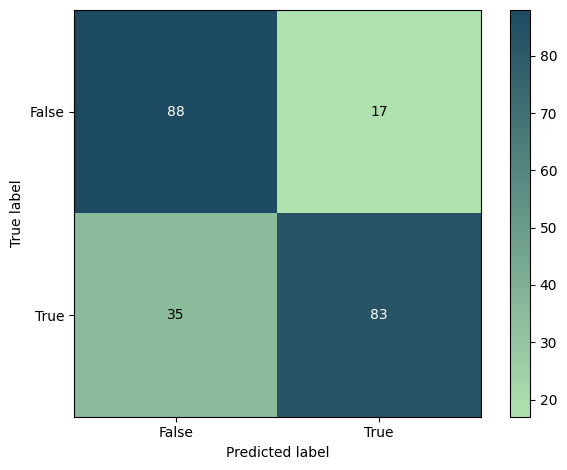

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 83
     - False Positive           : 17
     - True Negative            : 88
     - False Negative           : 35
     - True Positive Rate       :  0.7033898305084746
     - True Negative Rate       :  0.8380952380952381
     - Positive Predictive Value:  0.83
     - Negative predictive value:  0.7154471544715447
     - False Positive Rate      :  0.1619047619047619
     - False Negative Rate      :  0.2966101694915254
     - False Discovery Rate     :  0.17



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 256
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.721973094170

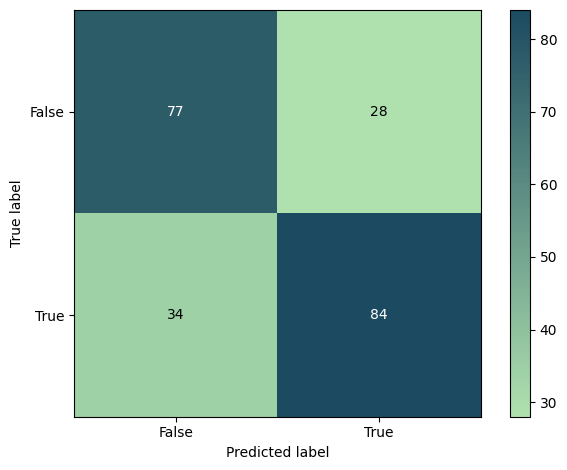

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 84
     - False Positive           : 28
     - True Negative            : 77
     - False Negative           : 34
     - True Positive Rate       :  0.711864406779661
     - True Negative Rate       :  0.7333333333333333
     - Positive Predictive Value:  0.75
     - Negative predictive value:  0.6936936936936937
     - False Positive Rate      :  0.26666666666666666
     - False Negative Rate      :  0.288135593220339
     - False Discovery Rate     :  0.25



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 16
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.74887892376681

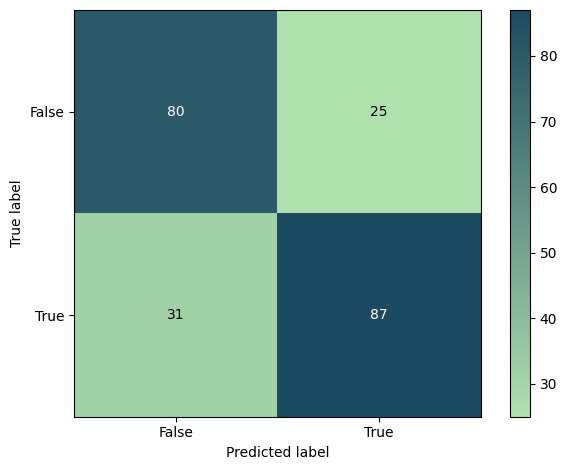

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 87
     - False Positive           : 25
     - True Negative            : 80
     - False Negative           : 31
     - True Positive Rate       :  0.7372881355932204
     - True Negative Rate       :  0.7619047619047619
     - Positive Predictive Value:  0.7767857142857143
     - Negative predictive value:  0.7207207207207207
     - False Positive Rate      :  0.23809523809523808
     - False Negative Rate      :  0.2627118644067797
     - False Discovery Rate     :  0.22321428571428573



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 32
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 7ms/

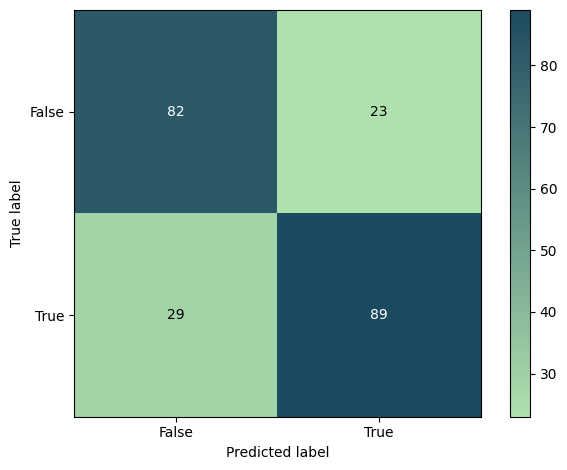

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 89
     - False Positive           : 23
     - True Negative            : 82
     - False Negative           : 29
     - True Positive Rate       :  0.7542372881355932
     - True Negative Rate       :  0.780952380952381
     - Positive Predictive Value:  0.7946428571428571
     - Negative predictive value:  0.7387387387387387
     - False Positive Rate      :  0.21904761904761905
     - False Negative Rate      :  0.2457627118644068
     - False Discovery Rate     :  0.20535714285714285



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 64
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 9ms/s

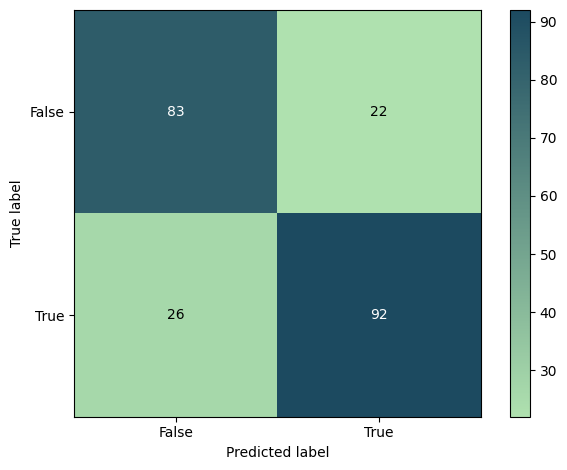

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 92
     - False Positive           : 22
     - True Negative            : 83
     - False Negative           : 26
     - True Positive Rate       :  0.7796610169491526
     - True Negative Rate       :  0.7904761904761904
     - Positive Predictive Value:  0.8070175438596491
     - Negative predictive value:  0.7614678899082569
     - False Positive Rate      :  0.20952380952380953
     - False Negative Rate      :  0.22033898305084745
     - False Discovery Rate     :  0.19298245614035087



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 128
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 7m

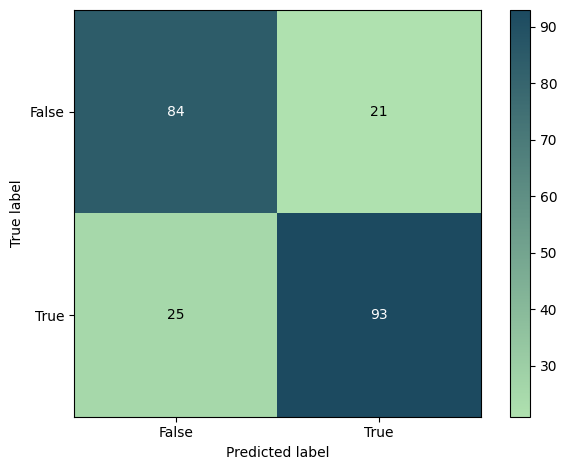

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 93
     - False Positive           : 21
     - True Negative            : 84
     - False Negative           : 25
     - True Positive Rate       :  0.788135593220339
     - True Negative Rate       :  0.8
     - Positive Predictive Value:  0.8157894736842105
     - Negative predictive value:  0.7706422018348624
     - False Positive Rate      :  0.2
     - False Negative Rate      :  0.211864406779661
     - False Discovery Rate     :  0.18421052631578946



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 256
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.721973094170403

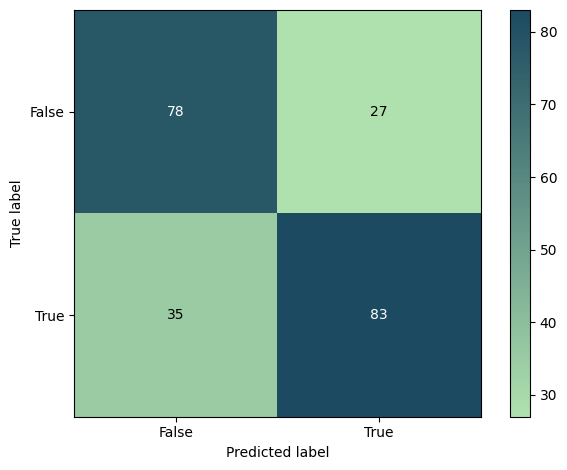

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 83
     - False Positive           : 27
     - True Negative            : 78
     - False Negative           : 35
     - True Positive Rate       :  0.7033898305084746
     - True Negative Rate       :  0.7428571428571429
     - Positive Predictive Value:  0.7545454545454545
     - Negative predictive value:  0.6902654867256637
     - False Positive Rate      :  0.2571428571428571
     - False Negative Rate      :  0.2966101694915254
     - False Discovery Rate     :  0.24545454545454545



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 16
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 10ms/

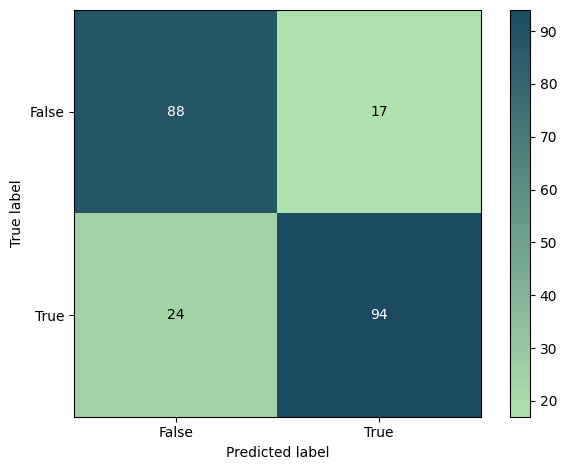

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 17
     - True Negative            : 88
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.8380952380952381
     - Positive Predictive Value:  0.8468468468468469
     - Negative predictive value:  0.7857142857142857
     - False Positive Rate      :  0.1619047619047619
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.15315315315315314



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 32
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 11ms/

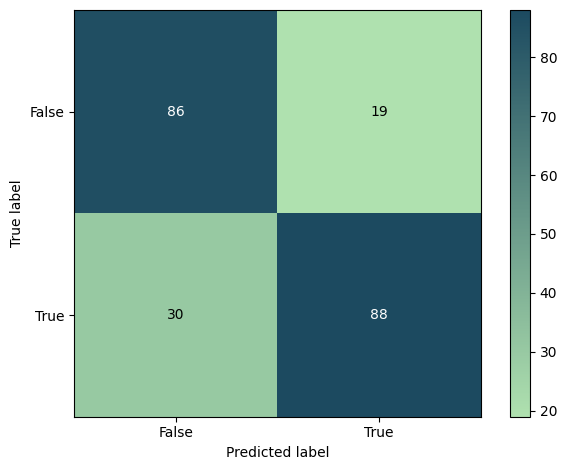

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 88
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 30
     - True Positive Rate       :  0.7457627118644068
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.822429906542056
     - Negative predictive value:  0.7413793103448276
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.2542372881355932
     - False Discovery Rate     :  0.17757009345794392



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 64
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 11ms/s

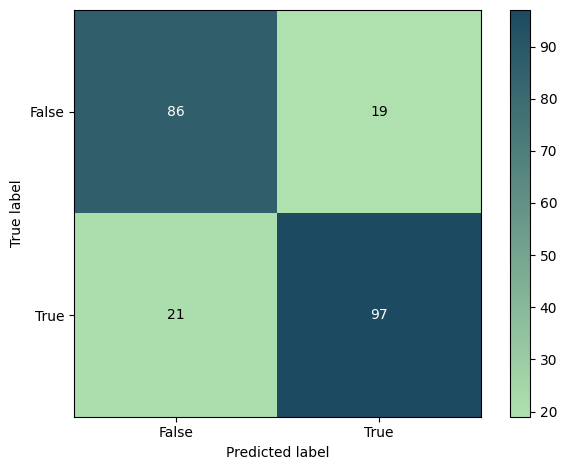

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8362068965517241
     - Negative predictive value:  0.8037383177570093
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.16379310344827586



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 128
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 10m

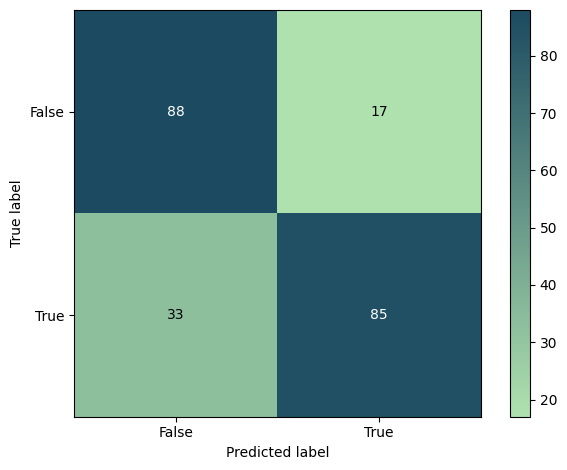

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 85
     - False Positive           : 17
     - True Negative            : 88
     - False Negative           : 33
     - True Positive Rate       :  0.7203389830508474
     - True Negative Rate       :  0.8380952380952381
     - Positive Predictive Value:  0.8333333333333334
     - Negative predictive value:  0.7272727272727273
     - False Positive Rate      :  0.1619047619047619
     - False Negative Rate      :  0.2796610169491525
     - False Discovery Rate     :  0.16666666666666666



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 256
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 14ms

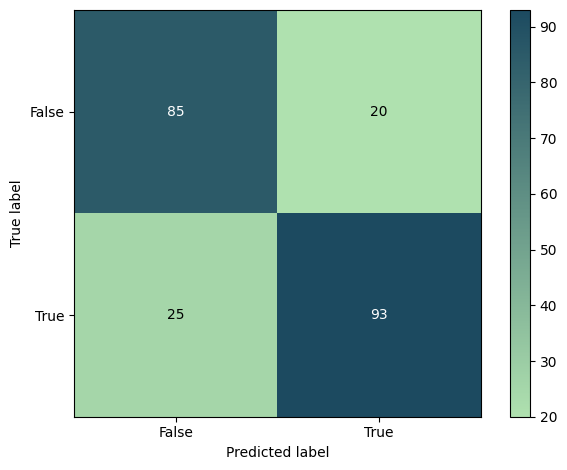

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 93
     - False Positive           : 20
     - True Negative            : 85
     - False Negative           : 25
     - True Positive Rate       :  0.788135593220339
     - True Negative Rate       :  0.8095238095238095
     - Positive Predictive Value:  0.8230088495575221
     - Negative predictive value:  0.7727272727272727
     - False Positive Rate      :  0.19047619047619047
     - False Negative Rate      :  0.211864406779661
     - False Discovery Rate     :  0.17699115044247787



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 16
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 24ms/

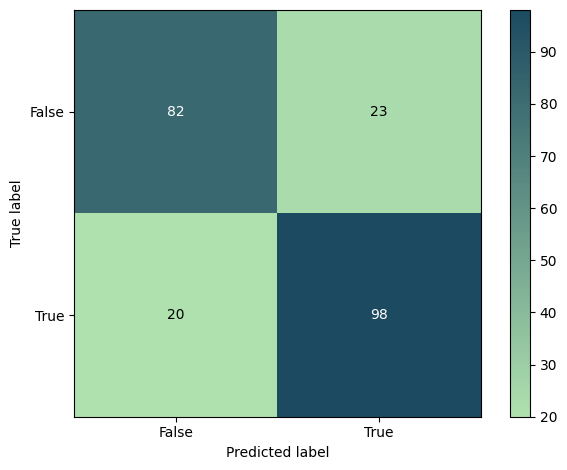

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 98
     - False Positive           : 23
     - True Negative            : 82
     - False Negative           : 20
     - True Positive Rate       :  0.8305084745762712
     - True Negative Rate       :  0.780952380952381
     - Positive Predictive Value:  0.8099173553719008
     - Negative predictive value:  0.803921568627451
     - False Positive Rate      :  0.21904761904761905
     - False Negative Rate      :  0.1694915254237288
     - False Discovery Rate     :  0.19008264462809918



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 32
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 21ms/

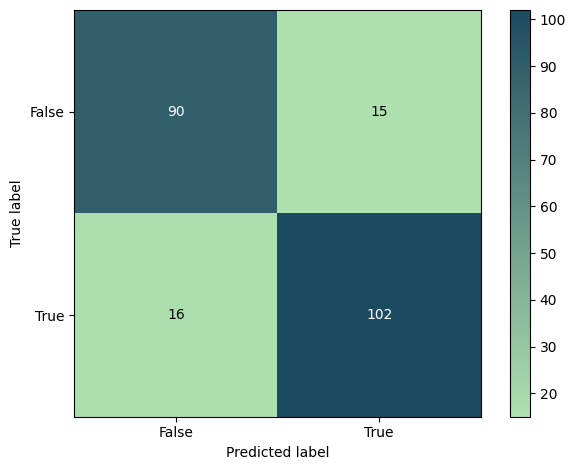

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 102
     - False Positive           : 15
     - True Negative            : 90
     - False Negative           : 16
     - True Positive Rate       :  0.864406779661017
     - True Negative Rate       :  0.8571428571428571
     - Positive Predictive Value:  0.8717948717948718
     - Negative predictive value:  0.8490566037735849
     - False Positive Rate      :  0.14285714285714285
     - False Negative Rate      :  0.13559322033898305
     - False Discovery Rate     :  0.1282051282051282



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 64
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 23m

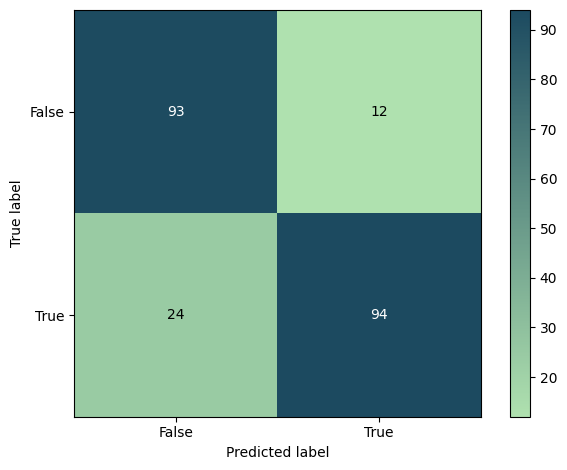

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 12
     - True Negative            : 93
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.8857142857142857
     - Positive Predictive Value:  0.8867924528301887
     - Negative predictive value:  0.7948717948717948
     - False Positive Rate      :  0.11428571428571428
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.11320754716981132



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 128
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 24

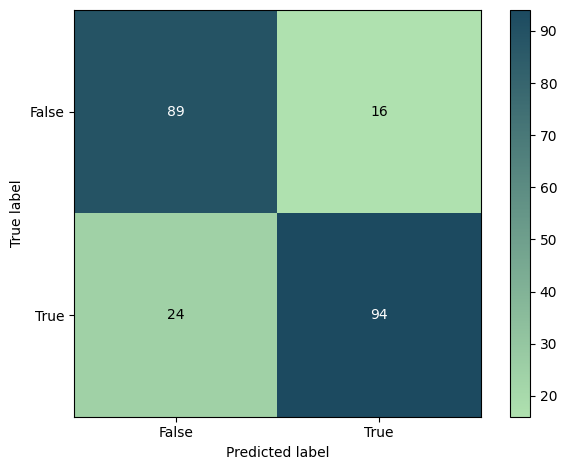

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8545454545454545
     - Negative predictive value:  0.7876106194690266
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.14545454545454545



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 256
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 0s 24m

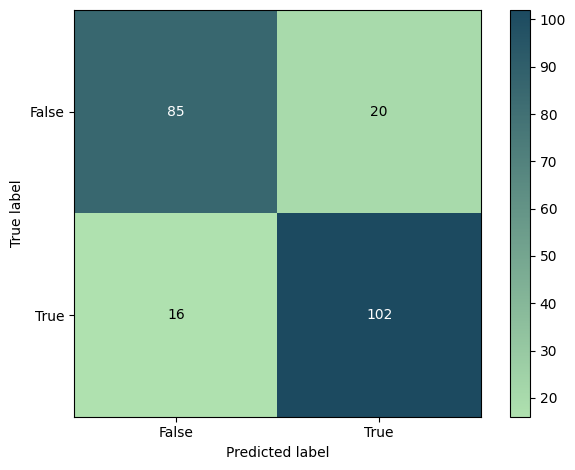

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 102
     - False Positive           : 20
     - True Negative            : 85
     - False Negative           : 16
     - True Positive Rate       :  0.864406779661017
     - True Negative Rate       :  0.8095238095238095
     - Positive Predictive Value:  0.8360655737704918
     - Negative predictive value:  0.8415841584158416
     - False Positive Rate      :  0.19047619047619047
     - False Negative Rate      :  0.13559322033898305
     - False Discovery Rate     :  0.16393442622950818



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 16
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 1s 69

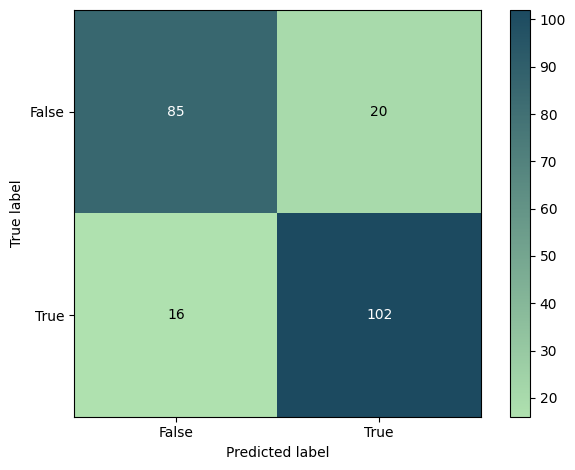

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 102
     - False Positive           : 20
     - True Negative            : 85
     - False Negative           : 16
     - True Positive Rate       :  0.864406779661017
     - True Negative Rate       :  0.8095238095238095
     - Positive Predictive Value:  0.8360655737704918
     - Negative predictive value:  0.8415841584158416
     - False Positive Rate      :  0.19047619047619047
     - False Negative Rate      :  0.13559322033898305
     - False Discovery Rate     :  0.16393442622950818



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 32
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 1s 63

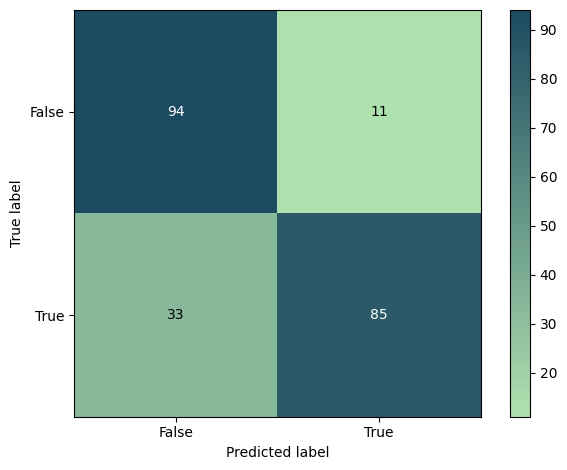

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 85
     - False Positive           : 11
     - True Negative            : 94
     - False Negative           : 33
     - True Positive Rate       :  0.7203389830508474
     - True Negative Rate       :  0.8952380952380953
     - Positive Predictive Value:  0.8854166666666666
     - Negative predictive value:  0.7401574803149606
     - False Positive Rate      :  0.10476190476190476
     - False Negative Rate      :  0.2796610169491525
     - False Discovery Rate     :  0.11458333333333333



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 64
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 1s 63m

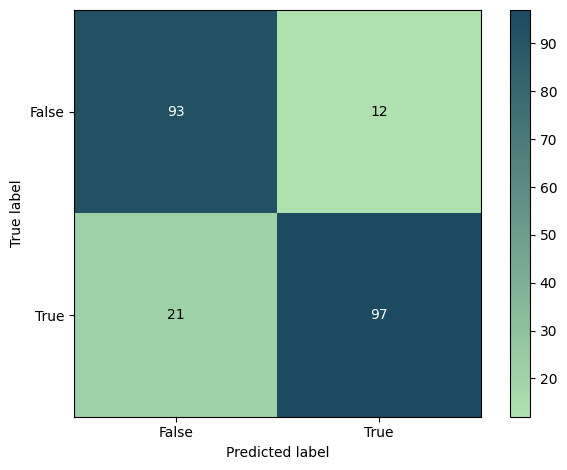

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 12
     - True Negative            : 93
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.8857142857142857
     - Positive Predictive Value:  0.8899082568807339
     - Negative predictive value:  0.8157894736842105
     - False Positive Rate      :  0.11428571428571428
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.11009174311926606



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 128
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 1s 5

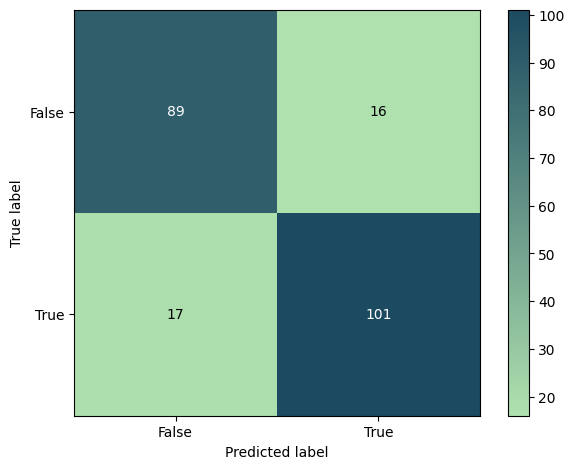

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 101
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 17
     - True Positive Rate       :  0.8559322033898306
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8632478632478633
     - Negative predictive value:  0.839622641509434
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.1440677966101695
     - False Discovery Rate     :  0.13675213675213677



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 256
Epoch Num             : 100
audio_data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 56) (520,) (223, 90, 56) (223,)
7/7 [==============================] - 1s 61m

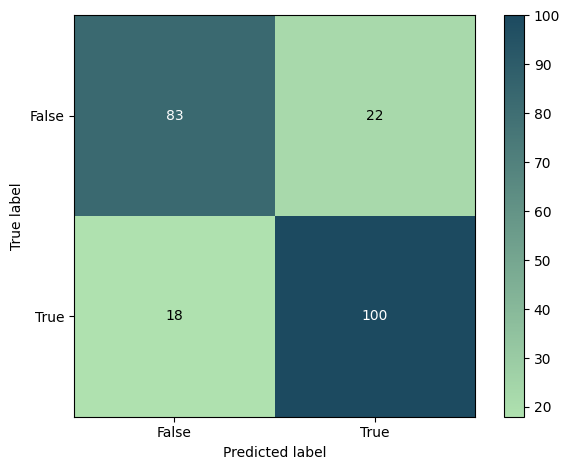

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 100
     - False Positive           : 22
     - True Negative            : 83
     - False Negative           : 18
     - True Positive Rate       :  0.847457627118644
     - True Negative Rate       :  0.7904761904761904
     - Positive Predictive Value:  0.819672131147541
     - Negative predictive value:  0.8217821782178217
     - False Positive Rate      :  0.20952380952380953
     - False Negative Rate      :  0.15254237288135594
     - False Discovery Rate     :  0.18032786885245902



##########################################


In [7]:
LSTM_grid_search(csv_path="../../../data/data_split_paths_CSVs/",
                 visual_data_dir="../../../data/visual_features/MediaPipe/mediaPipe_keypoints_data_UPD",
                 visual_data_mode="MediaPipe",
                 audio_data_dir="../../../data/audio_features/",
                 # coord_selection,
                 fusion_mode="+",
                 visual_approach_type="sequential",  # average or frame-based
                 audio_feature_type="MFCC",  # MFCC, RMS, Chroma
                 lstm_feat_size_lst=[16, 32, 64, 128, 256],
                 inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                 epochs_num=100,
                 batch_size=32,
                 threshold=0.5,
                 required_FPS=30,
                 input_length_in_seconds=3,
                 class_to_num_dict={"truth": 0, "lie": 1},
                 train_verbose=False)

# Let's search for good OpenFace parameter:

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

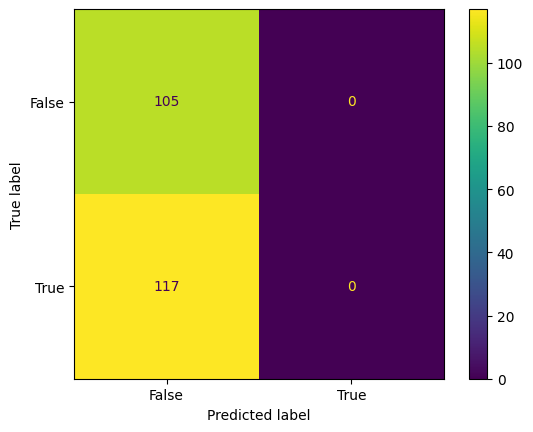




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

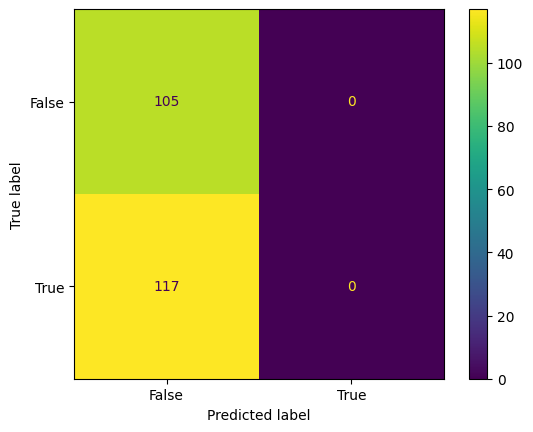




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

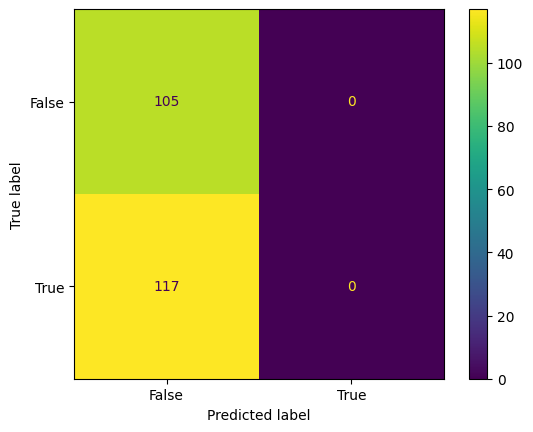




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

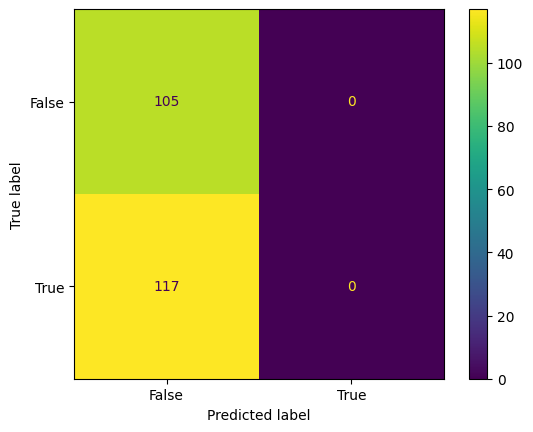




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

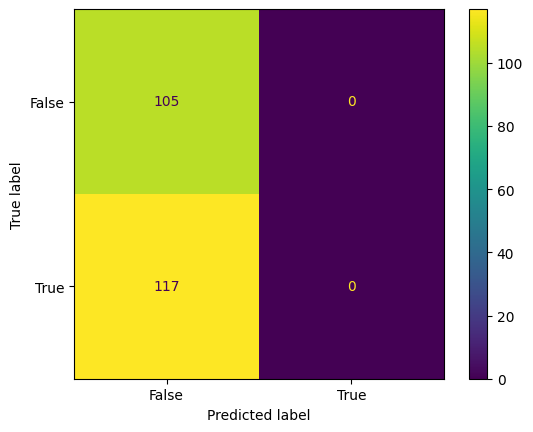




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

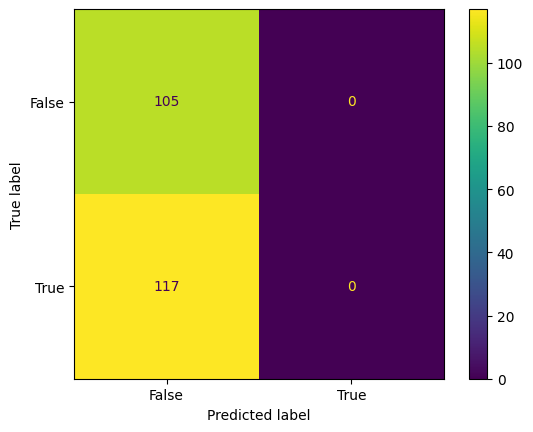




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

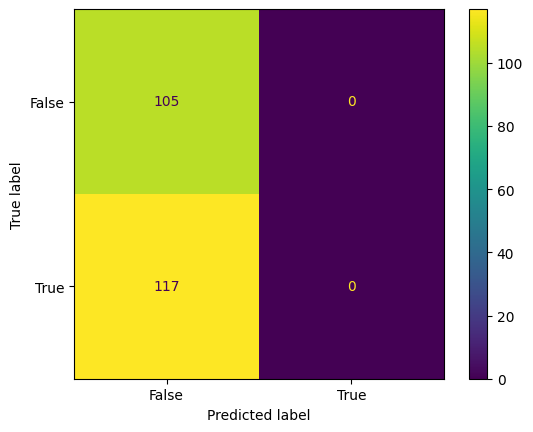




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

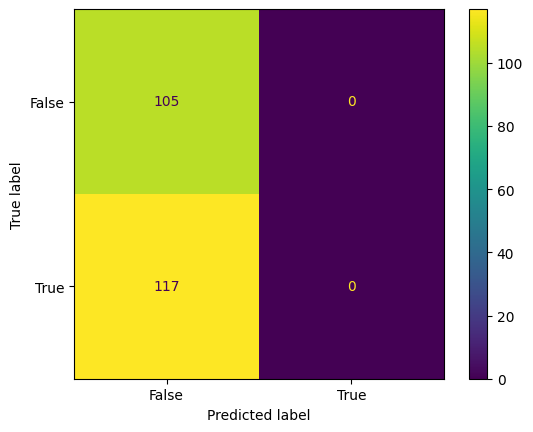




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

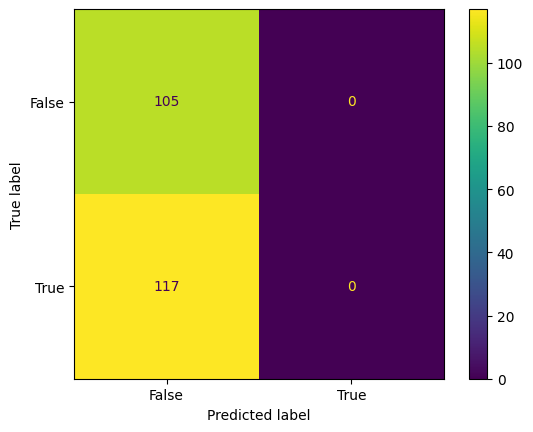




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

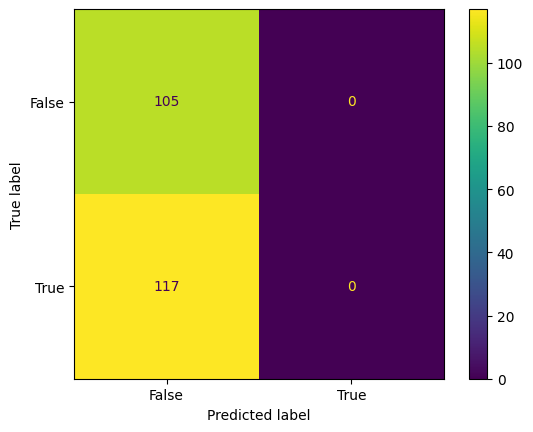




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

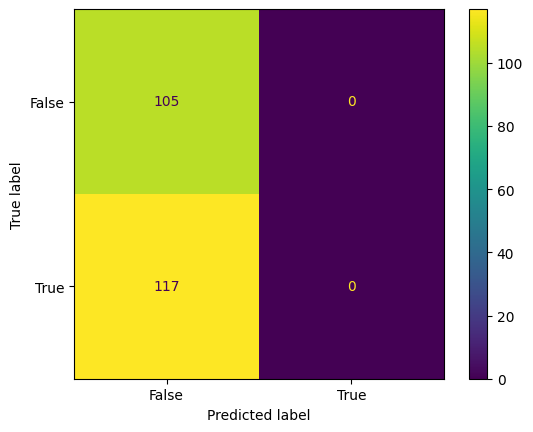




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

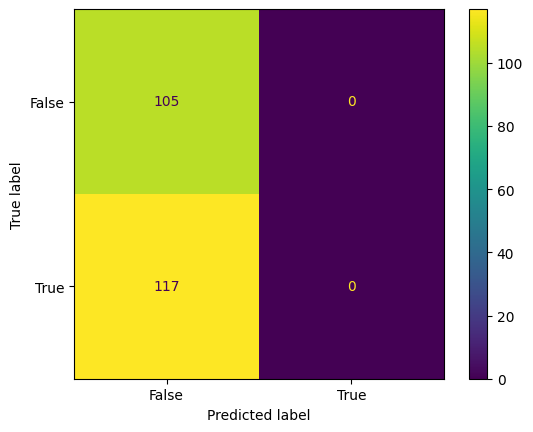




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

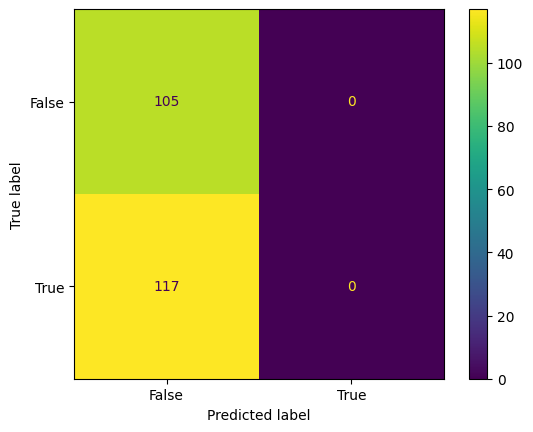




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 10ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

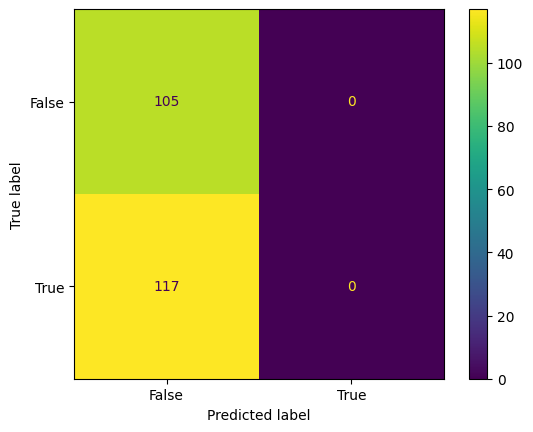




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 10ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

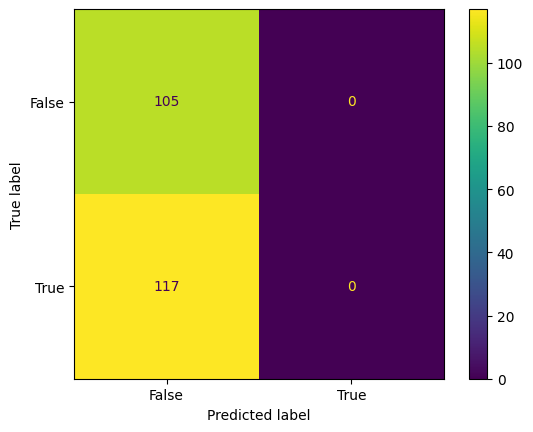




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 20ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

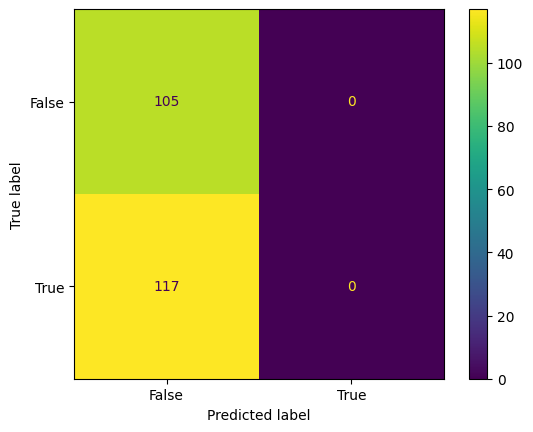




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 19ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

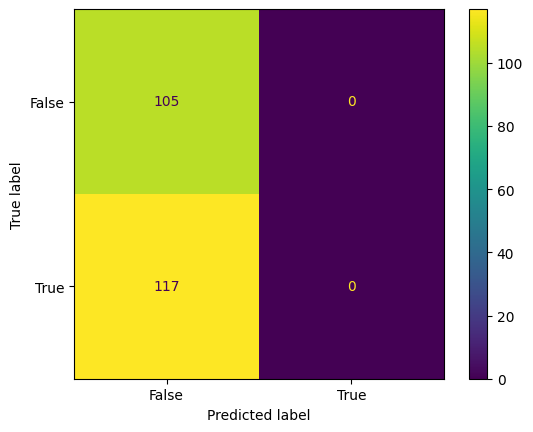




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 18ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

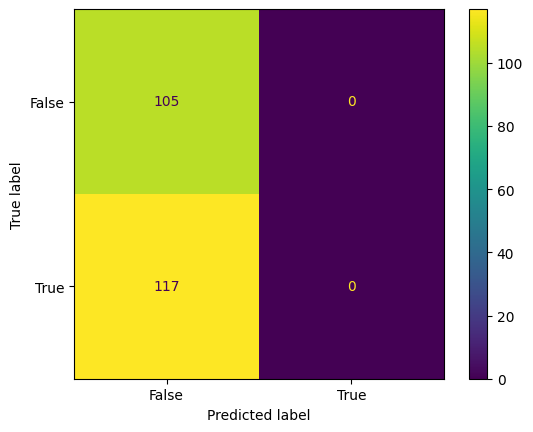




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 21ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

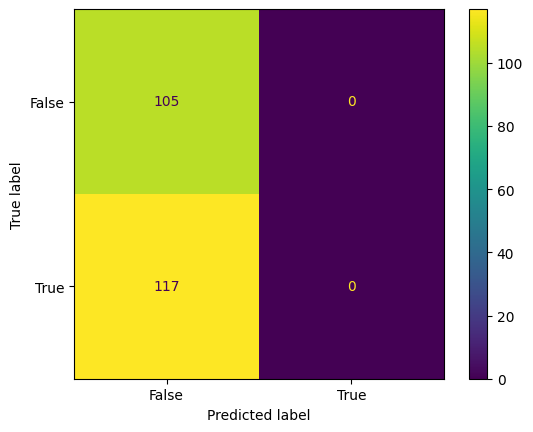




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 19ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

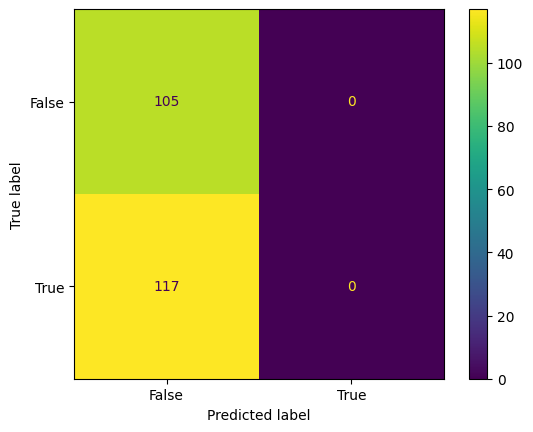




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 48ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

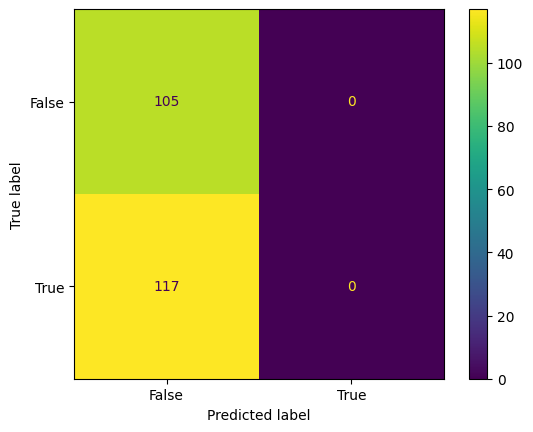




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 56ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

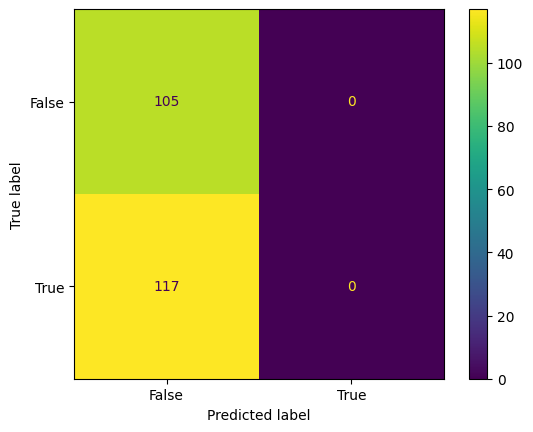




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 47ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

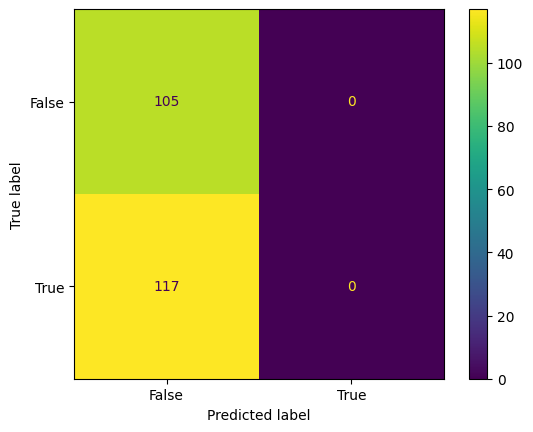




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 57ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

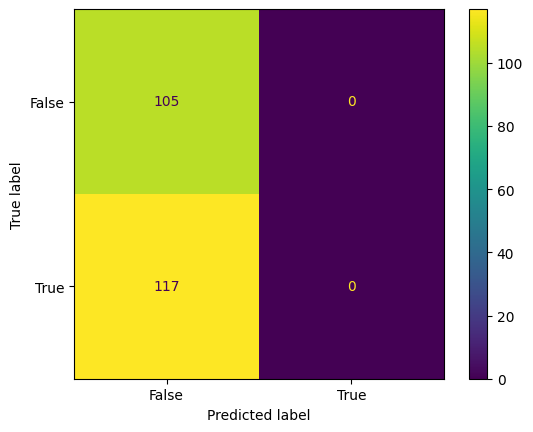




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 49ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

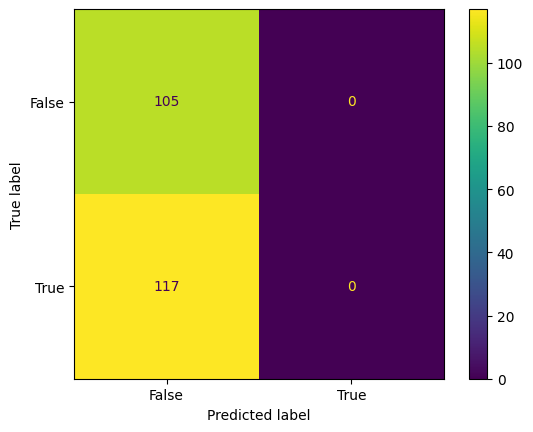




##########################################


In [2]:
LSTM_grid_search(csv_path="../../../data/data_split_paths_CSVs/",
                 visual_data_dir="../../../data/visual_features/OpenFace/PyFeatOutput/OpenFace",
                 visual_data_mode="OpenFace",
                 audio_data_dir="../../../data/audio_features/",
                 # coord_selection,
                 fusion_mode="+",
                 visual_approach_type="sequential",  # average or frame-based
                 audio_feature_type="MFCC",  # MFCC, RMS, Chroma
                 lstm_feat_size_lst=[10, 30, 64, 100, 120, 150],
                 inner_dense_layer_size_lst=[16, 32, 64, 128],
                 epochs_num=100,
                 batch_size=32,
                 threshold=0.5,
                 required_FPS=30,
                 input_length_in_seconds=3,
                 class_to_num_dict={"truth": 0, "lie": 1},
                 train_verbose=False)